In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

np.random.seed(37)

In [2]:
import itertools

indexes = list(itertools.product([0,1,2,3,4,5,6,7],[0,1,2],[0,1,2]))
print(indexes)

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 2, 0), (0, 2, 1), (0, 2, 2), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 2, 0), (1, 2, 1), (1, 2, 2), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 2, 0), (2, 2, 1), (2, 2, 2), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 2, 0), (3, 2, 1), (3, 2, 2), (4, 0, 0), (4, 0, 1), (4, 0, 2), (4, 1, 0), (4, 1, 1), (4, 1, 2), (4, 2, 0), (4, 2, 1), (4, 2, 2), (5, 0, 0), (5, 0, 1), (5, 0, 2), (5, 1, 0), (5, 1, 1), (5, 1, 2), (5, 2, 0), (5, 2, 1), (5, 2, 2), (6, 0, 0), (6, 0, 1), (6, 0, 2), (6, 1, 0), (6, 1, 1), (6, 1, 2), (6, 2, 0), (6, 2, 1), (6, 2, 2), (7, 0, 0), (7, 0, 1), (7, 0, 2), (7, 1, 0), (7, 1, 1), (7, 1, 2), (7, 2, 0), (7, 2, 1), (7, 2, 2)]


In [3]:
def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

In [4]:
def get_F(h, s, v):
    h_norm = normalize(
        h,
        {'actual': {'lower': 0, 'upper': 179}, 'desired': {'lower': 0, 'upper': 360}}
    )
    s_norm = normalize(
        s,
        {'actual': {'lower': 0, 'upper': 255}, 'desired': {'lower': 0, 'upper': 1}}
    )
    v_norm = normalize(
        v,
        {'actual': {'lower': 0, 'upper': 255}, 'desired': {'lower': 0, 'upper': 1}}
    )
    
    h_norm = np.array(h_norm).flatten()
    s_norm = np.array(s_norm).flatten()
    v_norm = np.array(v_norm).flatten()
    
    h_d = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
    s_d = {0:0, 1:0, 2:0}
    v_d = {0:0, 1:0, 2:0}

    for i in range(len(h_norm)):
        H = h_norm[i]
        ha = None
        if H >= 316 or H <= 20:
            ha = 0
        elif H >= 21 and H <= 40:
            ha = 1
        elif H >= 41 and H <= 75:
            ha = 2
        elif H >= 76 and H <= 155:
            ha = 3
        elif H >= 156 and H <= 190:
            ha = 4
        elif H >= 191 and H <= 270:
            ha = 5
        elif H >= 271 and H <= 295:
            ha = 6
        elif H >= 296 and H <= 315:
            ha = 7
        if ha not in h_d:
            h_d[ha] = 1
        else:
            h_d[ha] += 1

    for i in range(len(s_norm)):
        S = s_norm[i]
        sa = None
        if S >= 0 and S <= 0.2:
            sa = 0
        elif S > 0.2 and S <= 0.7:
            sa = 1
        elif S > 0.7 and S <= 1:
            sa = 2
        if sa not in s_d:
            s_d[sa] = 1
        else:
            s_d[sa] += 1

    for i in range(len(v_norm)):
        V = v_norm[i]
        va = None
        if V >= 0 and V <= 0.2:
            va = 0
        elif V > 0.2 and V <= 0.7:
            va = 1
        elif V > 0.7 and V <= 1:
            va = 2
        if va not in v_d:
            v_d[va] = 1
        else:
            v_d[va] += 1
            
    F = np.zeros((72,))
    
    for i in range(8):
        for j in range(3):
            for k in range(3):
                F[indexes.index((i, j, k))] = 9*h_d[i] + 3*s_d[j] + v_d[k]
    return F

In [5]:
data_dir_path = "C:\\Users\\Souvik\\Desktop\\Base Paper\\"

In [16]:
def process_video(fname):
    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()

    #print(success)

    count = 0
    while success:
        #cv2.imwrite(out_path+"frame%d.jpg" % count, image)     # save frame as JPEG file
        img2 = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
        h, s, v = img2[:,:,0], img2[:,:,1], img2[:,:,2]
        F = get_F(h, s, v)
        #print(F)
        colour_features.append(F)
        if(count%10 == 0):
            print("{count} images done".format(count=count))
        success, img = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1
        
    best_i = 0
    best_sc = -1

    for i in range(3,21):
        kmeans = KMeans(n_clusters=i, random_state=0).fit(colour_features)
        sc = silhouette_score(colour_features, kmeans.labels_)
        if(sc > best_sc):
            best_i = i
            best_sc = sc
        print(i, silhouette_score(colour_features, kmeans.labels_))

    kmeans = KMeans(n_clusters=best_i, random_state=0).fit(colour_features)
    cents = kmeans.cluster_centers_

    print(len(colour_features), len(kmeans.labels_))

    min_dict = {}
    min_frame= {}
    for i in range(len(kmeans.labels_)):
        t = np.linalg.norm(colour_features[i]-cents[kmeans.labels_[i]])
        if kmeans.labels_[i] not in min_dict:
            min_dict[kmeans.labels_[i]] = t
            min_frame[kmeans.labels_[i]] = i
        else:
            if(t < min_dict[kmeans.labels_[i]]):
                min_dict[kmeans.labels_[i]] = t
                min_frame[kmeans.labels_[i]] = i

    print(min_frame)

    key_frames = list(min_frame.values())

    count = 0

    cur_dir = fname[0:-4]
    print(cur_dir)
    os.mkdir(cur_dir)

    vidcap = cv2.VideoCapture(fname)
    success, img = vidcap.read()
    print('Read a new frame: ', success)

    while success:
        if count in key_frames:
            print(cur_dir + "\\" + str(count) + ".jpg")
            cv2.imwrite(cur_dir + "\\" + str(count) + ".jpg", img)
            plt.imshow(img)
            plt.show()
        success, img = vidcap.read()
        #print('Read a new frame: ', success)
        count += 1

C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_01.avi
0 images done
10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
3 0.5272723441381949
4 0.2922376784788602
5 0.31489064592499794
6 0.3162419357215038
7 0.29796657937834664
8 0.2901311348038066
9 0.2648660028165016
10 0.3028008026510268
11 0.32131296639469115
12 0.3160901433967012
13 0.29193587214506284
14 0.2841875259646288
15 0.2913245607580851
16 0.2993679070495592
17 0.28968664110337816
18 0.29431208122413455
19 0.26923571153045445
20 0.24641372380160556
70 70
{1: 20, 2: 14, 0: 59}
C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_01
Read a new frame:  True
C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_01\14.jpg


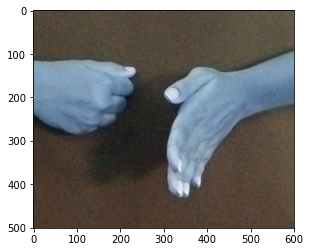

C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_01\20.jpg


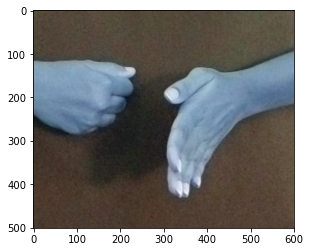

C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_01\59.jpg


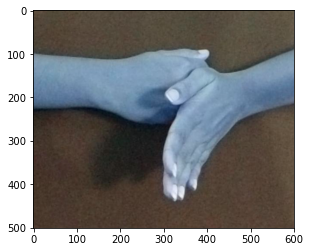

C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_02.avi
0 images done
10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
3 0.6525199751541471
4 0.6139746249989414
5 0.554072438283892
6 0.47711592119274054
7 0.450574223685906
8 0.3749540756809224
9 0.3892389331269702
10 0.3891990694636501
11 0.3657436862775932
12 0.37077858789442475
13 0.2880957281569091
14 0.3597819607400008
15 0.35089238370138026
16 0.2666712473512124
17 0.29791070259651464
18 0.30687429692598267
19 0.28562303567687714
20 0.29066355485611445
136 136
{2: 24, 0: 36, 1: 96}
C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_02
Read a new frame:  True
C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_02\24.jpg


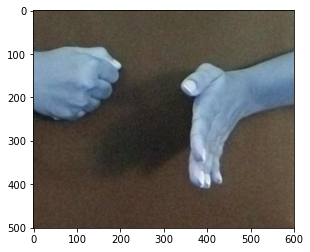

C:\Users\Souvik\Desktop\Test Video\accident_Crop_001_02\36.jpg


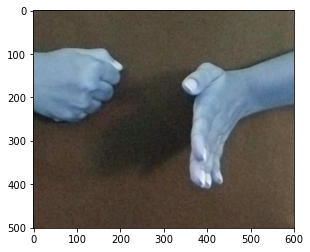

C:\Users\Souvik\Desktop\Test Video\accident_Crop_002_01.avi
0 images done
10 images done
20 images done
30 images done
40 images done
50 images done
60 images done
70 images done
3 0.5398118273958988
4 0.5859991596618682
5 0.5969542748489014
6 0.6194594234419118
7 0.6243780643270813
8 0.5999326329353021
9 0.565189812229678
10 0.5232612264420291
11 0.5123741764345785
12 0.45187407322899303
13 0.46223719198748464
14 0.42951021294849817
15 0.4143662834026364
16 0.40017501862518984
17 0.4022162197092776
18 0.3862561619142739
19 0.3600712820872759
20 0.36083703259362243
212 212
{6: 24, 2: 36, 0: 96, 3: 143, 5: 161, 1: 175, 4: 188}
C:\Users\Souvik\Desktop\Test Video\accident_Crop_002_01
Read a new frame:  True
C:\Users\Souvik\Desktop\Test Video\accident_Crop_002_01\24.jpg


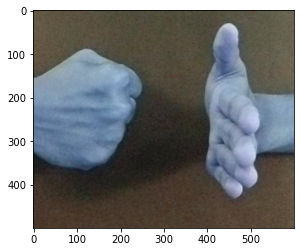

C:\Users\Souvik\Desktop\Test Video\accident_Crop_002_01\36.jpg


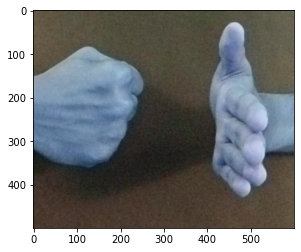

In [17]:
import os
from os import listdir

colour_features = []
count = 0

import cv2
for root, dirs, files in os.walk("C:\\Users\\Souvik\\Desktop\\Test Video", topdown=False):
    for name in files:
        print(os.path.join(root, name))
        process_video(os.path.join(root, name))